<a href="https://colab.research.google.com/github/NeerajMehta15/Deep-Learning-projects/blob/main/Car_Price_Prediction_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Datasets/playground-series-s4e9/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Datasets/playground-series-s4e9/test.csv')

In [4]:
styled_df = train.head().style.set_properties(**{"background-color": "#f9f9f9", "color": "#333333", "border": "1px solid #ccc", "font-weight": "normal"}).set_table_styles([{"selector": "th", "props": [("background-color", "#1976d2"), ("color", "white"), ("font-weight", "bold")]}]).format(precision=2)
styled_df

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [5]:
train.describe().style.format(precision=2).background_gradient(cmap="Blues")

,id,model_year,milage,price
count,188533.00,188533.00,188533.00,188533.00
mean,94266.00,2015.83,65705.30,43878.02
std,54424.93,5.66,49798.16,78819.52
min,0.00,1974.00,100.00,2000.00
25%,47133.00,2013.00,24115.00,17000.00
50%,94266.00,2017.00,57785.00,30825.00
75%,141399.00,2020.00,95400.00,49900.00
max,188532.00,2024.00,405000.00,2954083.00


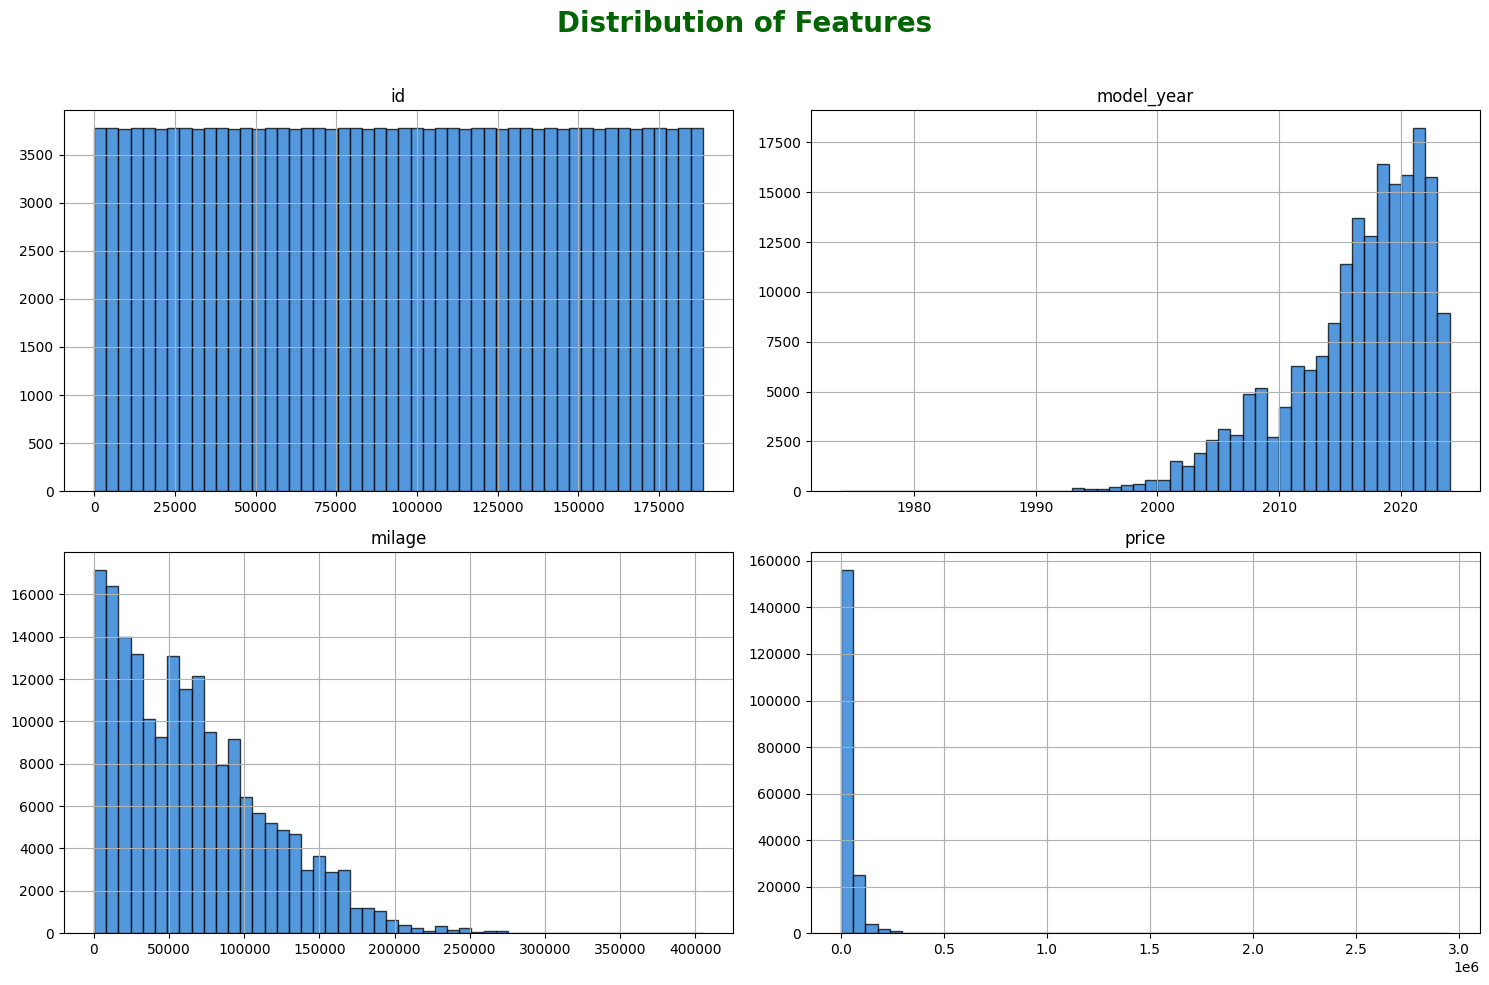

In [6]:
train.hist(
    bins=50,
    figsize=(15, 10),
    color='#1976d2',
    edgecolor='black',
    alpha=0.75
)

# Add global title and adjust layout
plt.suptitle("Distribution of Features", fontsize=20, fontweight='bold', color='darkgreen')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [7]:
# Check for missing values in each column
missing_values = train.isnull().sum()
print(missing_values)


id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64


**1. EDA**

In [8]:
sorted_values = sorted(train['brand'].unique())
print(sorted_values)

['Acura', 'Alfa', 'Aston', 'Audi', 'BMW', 'Bentley', 'Bugatti', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'FIAT', 'Ferrari', 'Ford', 'GMC', 'Genesis', 'Honda', 'Hummer', 'Hyundai', 'INFINITI', 'Jaguar', 'Jeep', 'Karma', 'Kia', 'Lamborghini', 'Land', 'Lexus', 'Lincoln', 'Lotus', 'Lucid', 'MINI', 'Maserati', 'Maybach', 'Mazda', 'McLaren', 'Mercedes-Benz', 'Mercury', 'Mitsubishi', 'Nissan', 'Plymouth', 'Polestar', 'Pontiac', 'Porsche', 'RAM', 'Rivian', 'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'smart']


In [9]:
train['model'].nunique()

1897

In [10]:
sorted_values = sorted(train['model'].unique())
print(sorted_values)

['124 Spider Abarth', '128 i', '135 i', '135 is', '1500 Big Horn', '1500 Cheyenne', '1500 Cheyenne Extended Cab', '1500 Classic SLT', '1500 Classic Tradesman', '1500 Classic Warlock', '1500 Laramie', '1500 Limited', '1500 Longhorn', '1500 Rebel', '1500 SLT', '1500 Sport', '1500 TRX', '1500 Tradesman/Express', '2 Launch Edition', '200 C', '200 Limited', '228 Gran Coupe i xDrive', '228 i', '230 i', '240SX Base', '2500 Big Horn', '2500 Laramie', '2500 Longhorn', '2500 Powerwagon', '2500 SLT', '2500 Tradesman', '300 Base', '300 S', '300 Touring', '300C Base', '300C SRT8', '300M Base', '300ZX Base', '320 i xDrive', '323 Ci', '325 Ci', '325 i', '325 xi', '328 i', '328 i xDrive', '328 xi', '330 330i xDrive', '330 i', '330 i xDrive', '330e iPerformance', '335 i', '335 i xDrive', '335 is', '340 i', '3500 Laramie', '3500 SLT', '3500 Tradesman', '350Z Enthusiast', '350Z NISMO', '350Z Touring', '370Z Base', '370Z NISMO', '370Z NISMO Tech', '370Z Touring', '428 Gran Coupe i xDrive', '428 i', '428 i

In [11]:
value_counts = train['fuel_type'].value_counts()
print(value_counts)


fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64


In [12]:
temp = train[train['fuel_type'].isna()]
temp1 = temp.head().style.set_properties(**{"background-color": "#f9f9f9", "color": "#333333", "border": "1px solid #ccc", "font-weight": "normal"}).set_table_styles([{"selector": "th", "props": [("background-color", "#1976d2"), ("color", "white"), ("font-weight", "bold")]}]).format(precision=2)
temp1

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
11,11,Tesla,Model S P100D,2015,81500,nan,Electric Motor Electric Fuel System,1-Speed A/T,Gray,White,None reported,Yes,19000
32,32,Tesla,Model S P100D,2018,30300,nan,518.0HP Electric Motor Electric Fuel System,A/T,White,White,None reported,Yes,64000
51,51,Tesla,Model 3 Long Range,2020,38360,nan,Dual Motor - Standard,Automatic,White,Black,None reported,nan,59598
52,52,Tesla,Model X 75D,2021,88000,nan,518.0HP Electric Motor Electric Fuel System,1-Speed A/T,Black,Black,None reported,Yes,53600
161,161,Tesla,Model S Long Range,2021,9500,nan,670.0HP Electric Motor Electric Fuel System,A/T,White,Beige,None reported,Yes,89999


In [13]:
train['fuel_type'] = train['fuel_type'].fillna('Electric')
test['fuel_type'] = test['fuel_type'].fillna('Electric')

In [14]:
pattern_1 = r"(\d+\.?\d*)\s*HP"
pattern_2 = r"(\d+\.?\d*)\s*L"
pattern = r"(\d+)\s*Cylinder"

train['engine_power'] = train['engine'].apply(
    lambda x: re.search(pattern_1, x).group(1) if re.search(pattern_1, x) else None)

train['engine_details'] = train['engine'].apply(
    lambda x: re.sub(pattern_1, '', x).strip() if isinstance(x, str) else None
)

train['engine_capacity'] = train['engine_details'].apply(
    lambda x: re.search(pattern_2, x).group(1) if re.search(pattern_2, x) else None)

train['engine_type'] = train['engine_details'].apply(
    lambda x: re.sub(pattern_2, '', x).strip() if isinstance(x, str) else None
)

train['engine_cylinder'] = train['engine'].apply(
    lambda x: re.search(pattern, x).group(1) if isinstance(x, str) and re.search(pattern, x) else None
)

In [15]:
test['engine_power'] = test['engine'].apply(
    lambda x: re.search(pattern_1, x).group(1) if re.search(pattern_1, x) else None)

test['engine_details'] = test['engine'].apply(
    lambda x: re.sub(pattern_1, '', x).strip() if isinstance(x, str) else None
)

test['engine_capacity'] = test['engine_details'].apply(
    lambda x: re.search(pattern_2, x).group(1) if re.search(pattern_2, x) else None)

test['engine_type'] = test['engine_details'].apply(
    lambda x: re.sub(pattern_2, '', x).strip() if isinstance(x, str) else None
)

test['engine_cylinder'] = test['engine'].apply(
    lambda x: re.search(pattern, x).group(1) if isinstance(x, str) and re.search(pattern, x) else None
)

In [16]:
train['engine_power'] = train['engine_power'].fillna(0)
train['engine_cylinder'] = train['engine_cylinder'].fillna(0)

test['engine_power'] = test['engine_power'].fillna(0)
test['engine_cylinder'] = test['engine_cylinder'].fillna(0)

In [17]:
transmission_type_counts = train['transmission'].value_counts()
print(transmission_type_counts)


transmission
A/T                                                   49904
8-Speed A/T                                           20645
Transmission w/Dual Shift Mode                        19255
6-Speed A/T                                           18044
6-Speed M/T                                           11998
7-Speed A/T                                           11124
Automatic                                             10691
8-Speed Automatic                                      8431
10-Speed A/T                                           8044
9-Speed A/T                                            3866
5-Speed A/T                                            3217
10-Speed Automatic                                     3164
6-Speed Automatic                                      2799
4-Speed A/T                                            2546
5-Speed M/T                                            2409
9-Speed Automatic                                      2325
CVT Transmission           

In [18]:
def categorize_transmission(trans):
    if "Manual" in trans or "M/T" in trans:
        return "Manual"
    elif "Automatic" in trans or "A/T" in trans or "Electronically Controlled" in trans:
        return "Automatic"
    elif "CVT" in trans:
        return "CVT"
    elif "DCT" in trans:
        return "DCT"
    elif "Single-Speed" in trans or "1-Speed" in trans:
        return "Single-Speed"
    elif "2-Speed" in trans:
        return "2-Speed"
    elif any(speed in trans for speed in ["3-Speed", "4-Speed", "5-Speed", "6-Speed", "7-Speed", "8-Speed", "9-Speed", "10-Speed"]):
        return "Multi-Speed"
    else:
        return "Other"

train['transmission_category'] = train['transmission'].apply(categorize_transmission)
test['transmission_category'] = test['transmission'].apply(categorize_transmission)



In [19]:
train['ext_col'].unique()

array(['Yellow', 'Silver', 'Blue', 'Black', 'White',
       'Snowflake White Pearl Metallic', 'Gray', 'Green',
       'Santorini Black Metallic', 'Purple', 'Ebony Twilight Metallic',
       'Red', 'Magnetite Black Metallic', 'Diamond Black', 'Vega Blue',
       'Beige', 'Gold', 'Platinum White Pearl', 'Metallic',
       'White Frost Tri-Coat', 'Firecracker Red Clearcoat',
       'Phytonic Blue Metallic', 'Blu', 'Orange', 'Brown',
       'Brilliant Silver Metallic', 'Black Raven', 'Black Clearcoat',
       'Firenze Red', 'Agate Black Metallic', 'Glacial White Pearl',
       'Majestic Plum Metallic', 'designo Diamond White Metallic',
       'Oxford White', 'Black Sapphire Metallic', 'Mythos Black',
       'Granite Crystal Clearcoat Metallic', 'White Diamond Tri-Coat',
       'Magnetite Gray Metallic', 'Carpathian Grey Premium Metallic',
       'designo Diamond White Bright',
       'Phantom Black Pearl Effect / Black Roof', 'Nebula Gray Pearl',
       'Deep Crystal Blue Mica', 'Flame Red

In [20]:
def categorize_color_ext(color):
    # Define categories based on color
    neutral_colors = ['White', 'Black', 'Gray', 'Silver', 'Beige', 'Platinum', 'Ivory', 'Charcoal', 'Bronze']
    metallic_colors = ['Metallic', 'Pearl', 'Clearcoat', 'Tri-Coat', 'Bright', 'Satin', 'Matte']
    bright_colors = ['Red', 'Yellow', 'Blue', 'Green', 'Orange', 'Purple', 'Pink']
    luxury_colors = ['Custom', 'Designo', 'Premium', 'Magno', 'Exclusive', 'Obsidian', 'Nero']

    # Check which category the color belongs to
    if any(neutral in color for neutral in neutral_colors):
        return 'Neutral'
    elif any(metallic in color for metallic in metallic_colors):
        return 'Metallic'
    elif any(bright in color for bright in bright_colors):
        return 'Bright'
    elif any(luxury in color for luxury in luxury_colors):
        return 'Luxury/Exotic'
    else:
        return 'Other'

# Apply the categorization function to the 'ext_col' column
train['ext_color_category'] = train['ext_col'].apply(categorize_color_ext)
test['ext_color_category'] = test['ext_col'].apply(categorize_color_ext)



In [21]:

color_categories = {
    'Neutral': ['White', 'Black', 'Beige', 'Gray', 'Silver', 'Gold', 'Tan', 'Ivory', 'Platinum',
                'Pearl', 'Cloud', 'Charcoal', 'Graphite', 'Slate', 'Cappuccino', 'Tan/Ebony',
                'Medium Ash Gray', 'Light Titanium', 'Light Slate', 'Beige/Black', 'Graystone',
                'Ceramic', 'Mocha', 'Beige', 'Light Gray', 'Ash', 'Nougat Brown'],
    'Dark': ['Black', 'Dark Galvanized', 'Ebony', 'Jet Black', 'Onyx', 'Charcoal Black', 'Black Onyx',
             'Obsidian Black', 'Black/Gun Metal', 'Deep Garnet', 'Dark Ash', 'Black/Red', 'Black/Graphite',
             'Black/Saddle Brown', 'Black/Stone Grey', 'Black/Red Stitching', 'Titan Black', 'AMG Black',
             'Deep Cypress'],
    'Light': ['White', 'Beige', 'Light Platinum', 'Light Titanium', 'Ivory', 'Light Gray', 'Very Light Cashmere'],
    'Red': ['Red', 'Rioja Red', 'Pimento Red', 'Classic Red', 'Sakhir Orange', 'Magma Red'],
    'Blue': ['Blue', 'Navy Pier', 'Charles Blue', 'Cobalt Blue'],
    'Brown': ['Brown', 'Chestnut', 'Walnut', 'Saddle Brown', 'Caramel', 'Brandy', 'Rock Gray', 'Cocoa',
              'Espresso', 'Chestnut', 'Camel', 'Boulder', 'Amber', 'Sandstone'],
    'Green': ['Green', 'Agave Green'],
    'Orange': ['Orange', 'Sakhir Orange', 'Tangerine', 'Kyalami Orange'],
    'Yellow': ['Yellow'],
    'Other': ['–', 'Boulder', 'Parchment.', 'Ebony.', 'Beige / Black', 'Graystone', 'Mistral Gray / Raven',
              'Giallo Taurus / Nero Ade', 'Tension', 'Medium Pewter', 'Ceramic', 'Magma Red', 'Bianco Polar',
              'Sport', 'Graphite w/Gun Metal', 'Porpoise', 'Rhapsody Blue', 'Sahara Tan', 'Tupelo', 'Gideon']
}

# Function to categorize colors
def categorize_color_int(color):
    for category, colors in color_categories.items():
        if any(c.lower() in color.lower() for c in colors):
            return category
    return 'Other'

# Apply categorization to the DataFrame
train['int_color_category'] = train['int_col'].apply(categorize_color_int)
test['int_color_category'] = test['int_col'].apply(categorize_color_int)


In [22]:
train['accident'].nunique()
train['accident_category'] = train['accident'].apply(lambda x: 0 if x == "None reported" else 1)



In [23]:
train['clean_title'].unique()
train['clean_title'] = train['clean_title'].fillna("No")
test['clean_title'] = test['clean_title'].fillna("No")

In [24]:
styled_df = train.head().style.set_properties(**{"background-color": "#f9f9f9", "color": "#333333", "border": "1px solid #ccc", "font-weight": "normal"}).set_table_styles([{"selector": "th", "props": [("background-color", "#1976d2"), ("color", "white"), ("font-weight", "bold")]}]).format(precision=2)
styled_df

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,engine_power,engine_details,engine_capacity,engine_type,engine_cylinder,transmission_category,ext_color_category,int_color_category,accident_category
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6L 4 Cylinder Engine Gasoline Fuel,1.6,4 Cylinder Engine Gasoline Fuel,4,Automatic,Bright,Neutral,0
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9L 8 Cylinder Engine Gasoline Fuel,3.9,8 Cylinder Engine Gasoline Fuel,8,Automatic,Neutral,Neutral,1
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3L 8 Cylinder Engine Flex Fuel Capability,5.3,8 Cylinder Engine Flex Fuel Capability,8,Automatic,Bright,Neutral,0
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0L 8 Cylinder Engine Gasoline Fuel,5.0,8 Cylinder Engine Gasoline Fuel,8,Other,Neutral,Neutral,0
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0L 4 Cylinder Engine Gasoline Fuel,2.0,4 Cylinder Engine Gasoline Fuel,4,Automatic,Neutral,Neutral,0


In [25]:
data = ['brand','model','model_year','milage','fuel_type','accident_category','clean_title','engine_power','engine_capacity','engine_cylinder','transmission_category','ext_color_category',
 'int_color_category','price']

In [26]:
train_1 = train[data]

In [40]:
# Step 1: Separate numerical and categorical columns
numerical_columns = [col for col in train_1.columns if train_1[col].dtype in ['int64', 'float64']]
categorical_columns = [col for col in train_1.columns if col not in numerical_columns]

# Threshold for high cardinality
high_cardinality_threshold = 20

# Step 2: Separate high and low cardinality columns within categorical columns
high_cardinality_columns = [col for col in categorical_columns if train_1[col].nunique() > high_cardinality_threshold]
low_cardinality_columns = [col for col in categorical_columns if col not in high_cardinality_columns]

# Step 3: Perform target encoding for high cardinality columns
for col in high_cardinality_columns:
    target_means = train_1.groupby(col)['price'].mean()  # Calculate mean target for each category
    train_1[f'{col}_target_enc'] = train_1[col].map(target_means)  # Map target mean to the column

# Step 4: Perform one-hot encoding for low cardinality columns
train_1 = pd.get_dummies(train_1, columns=low_cardinality_columns, drop_first=True)

# Step 5: Convert boolean columns to integers (True/False to 1/0)
for col in train_1.columns:
    if train_1[col].dtype == 'bool':
        train_1[col] = train_1[col].astype(int)

# Step 6: Drop original high cardinality columns to avoid redundancy
train_1 = train_1.drop(columns=high_cardinality_columns)

# Print the first few rows of the modified DataFrame
train_1.head()


,model_year,milage,accident_category,price,brand_target_enc,model_target_enc,engine_power_target_enc,engine_capacity_target_enc,fuel_type_E85 Flex Fuel_True,fuel_type_Electric_True,...,ext_color_category_Neutral_True,ext_color_category_Other_True,int_color_category_Brown_True,int_color_category_Dark_True,int_color_category_Green_True,int_color_category_Neutral_True,int_color_category_Orange_True,int_color_category_Other_True,int_color_category_Red_True,int_color_category_Yellow_True
0,2007,213000,0,4200,17162.015977,12832.716263,11606.278146,17785.924802,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2002,143250,1,4999,30712.595130,12663.379310,29171.578472,74204.837259,0,0,...,1,0,0,0,0,1,0,0,0,0
2,2002,136731,0,13900,41836.755127,23779.677419,23227.810827,35466.087331,1,0,...,0,0,0,0,0,1,0,0,0,0
3,2017,19500,0,45000,53556.327141,48915.842105,54126.838557,50868.464964,0,0,...,1,0,0,0,0,1,0,0,0,0
4,2021,7388,0,97500,51244.399541,64896.257198,36534.027094,32585.406522,0,0,...,1,0,0,0,0,1,0,0,0,0


In [41]:
# Print the first few rows of the modified DataFrame
train_1.head()

,model_year,milage,accident_category,price,brand_target_enc,model_target_enc,engine_power_target_enc,engine_capacity_target_enc,fuel_type_E85 Flex Fuel_True,fuel_type_Electric_True,...,ext_color_category_Neutral_True,ext_color_category_Other_True,int_color_category_Brown_True,int_color_category_Dark_True,int_color_category_Green_True,int_color_category_Neutral_True,int_color_category_Orange_True,int_color_category_Other_True,int_color_category_Red_True,int_color_category_Yellow_True
0,2007,213000,0,4200,17162.015977,12832.716263,11606.278146,17785.924802,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2002,143250,1,4999,30712.595130,12663.379310,29171.578472,74204.837259,0,0,...,1,0,0,0,0,1,0,0,0,0
2,2002,136731,0,13900,41836.755127,23779.677419,23227.810827,35466.087331,1,0,...,0,0,0,0,0,1,0,0,0,0
3,2017,19500,0,45000,53556.327141,48915.842105,54126.838557,50868.464964,0,0,...,1,0,0,0,0,1,0,0,0,0
4,2021,7388,0,97500,51244.399541,64896.257198,36534.027094,32585.406522,0,0,...,1,0,0,0,0,1,0,0,0,0


In [42]:
# Split into features and target
X = train_1.drop(columns=['price']).values
y = train_1['price'].values

In [43]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [46]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [47]:
# Define the regression model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [48]:
# Instantiate the model
input_dim = X_train.shape[1]
model = RegressionModel(input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: nan
Epoch [20/100], Loss: nan
Epoch [30/100], Loss: nan
Epoch [40/100], Loss: nan
Epoch [50/100], Loss: nan
Epoch [60/100], Loss: nan
Epoch [70/100], Loss: nan
Epoch [80/100], Loss: nan
Epoch [90/100], Loss: nan
Epoch [100/100], Loss: nan


In [35]:

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: nan


In [36]:
# Prediction
sample = X_test_tensor[0].unsqueeze(0)
predicted_price = model(sample).item()
print(f'Predicted Price: {predicted_price}')

Predicted Price: nan
